In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv
/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip
/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip


In [2]:
import zipfile
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re

In [3]:
with zipfile.ZipFile('/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip','r') as z:
    z.extractall('.')


In [4]:
with zipfile.ZipFile('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', 'r') as z:
    z.extractall('.')

In [5]:
with zipfile.ZipFile('/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip', 'r') as z:
    z.extractall('.')

In [6]:
train = pd.read_csv('labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)
train.head()
train.shape

(25000, 3)

In [7]:
def review_words(raw_review):
    #convert raw reviews into a string of words
    #1. remove HTML
    review_text = BeautifulSoup(raw_review).get_text()

    #2. remove non leters
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)

    #3. convert to lowercase, split into individual words
    words = letters_only.lower().split()

    #make a set of stopwords
    stops = set(stopwords.words('english'))

    #remove stopwords
    meaningful_words = [word for word in words if not word in stops]

    return(" ".join(meaningful_words))

In [8]:
train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [9]:
clean_review = review_words(train['review'][0])
print(clean_review)

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

In [10]:
num_reviews = train['review'].size
clean_train_reviews = []
for i in train['review']:
    clean_train_reviews.append(review_words(i))

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

#instantiate bag of words tool
vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None,
                            max_features = 5000)

train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()

In [12]:
train_data_features.shape

(25000, 5000)

In [13]:
vocab = vectorizer.get_feature_names_out()

#count of each word
dist = np.sum(train_data_features, axis = 0)

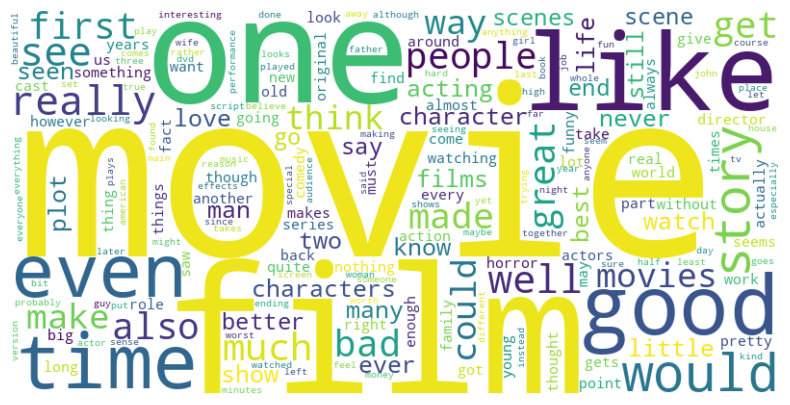

In [14]:
#world cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_frequencies = dict(zip(vocab, dist))
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate_from_frequencies(word_frequencies)

plt.figure(figsize = (10,  5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#initialize a rf classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt', max_depth = 6, max_leaf_nodes = 6 )
train_sentiment = train['sentiment'].tolist()

#fit the forest to the training set

forest = forest.fit(train_data_features, train['sentiment'])

In [16]:
#read the test data
test = pd.read_csv('testData.tsv', header = 0, delimiter = '\t', quoting = 3)

num_reviews = len(test['review'])
clean_test_reviews = []

for i in range(0,num_reviews):
    clean_review = review_words(test["review"][i])
    clean_test_reviews.append(clean_review)

test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

result_bag = forest.predict(test_data_features)

output_bag = pd.DataFrame({'id': test['id'],
                          'sentiment' : result_bag})

output_bag.to_csv('submission.csv', index = False, quoting = 3)